In [1]:
######################################################
# (0) 초기 설정
######################################################
import os, random, torch
import numpy as np

def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed) 
    random.seed(seed)  
    np.random.seed(seed)  
    torch.manual_seed(seed)  
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 예시
set_seed(123)

In [2]:
######################################################
# (1) 라이브러리 임포트 및 기본 설정
######################################################
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torch.utils.data import Subset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report

# 디바이스 설정 (GPU 사용 가능 시 'cuda', 아니면 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
######################################################
# (2) 하이퍼파라미터 & 경로 설정
######################################################
batch_size = 16
epochs = 20
# switch_epoch = epochs // 2
num_classes = 300
adamW_lr = 0.001
weight_decay = 1e-4
# SGD_lr = 1e-2
# SGD_momentum = 0.9
# SGD_step_size = 5
# SGD_gamma = 0.5

# 체크포인트 저장 폴더
checkpoint_dir = "./checkpoint_Ensemble"
os.makedirs(checkpoint_dir, exist_ok=True)  # 없으면 생성

# 결과 저장 시 모델 이름 표기를 위한 변수
model_name = "Ensemble"  # ★ 추가

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Training samples:   89179
Validation samples: 4694
Test samples:       4178
torch.Size([3, 380, 380])


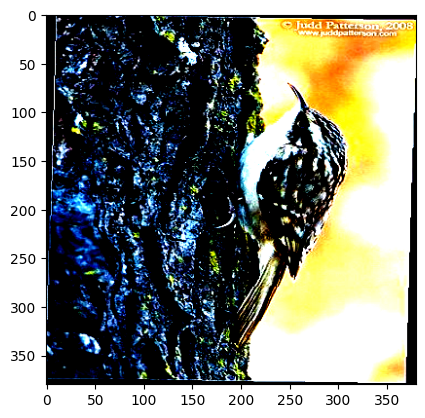

In [4]:
######################################################
# (3) 데이터 변환 & 데이터셋/로더 정의
######################################################
import torchvision

size = (380, 380)

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

origin_train_dataset = torchvision.datasets.ImageFolder(root="/home/student/workspace/data/train", transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root="/test/final_exam/challenge/test", transform=transform)

# train, valid 층화추출
# Dataset 전체의 클래스 레이블 가져오기
targets = [origin_train_dataset.targets[i] for i in range(len(origin_train_dataset))]

# train, valid 셋 클래스 비율을 맞추기 위한 층화추출
# 층화추출을 위한 StratifiedShuffleSplit 설정
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)  # train: 95%, valid: 5%

# train_index와 valid_index 생성
for train_index, valid_index in split.split(np.zeros(len(targets)), targets):
    train_indices = train_index
    valid_indices = valid_index

# Subset을 사용하여 Train과 Valid Dataset 생성
train_dataset = Subset(origin_train_dataset, train_indices)
validation_dataset = Subset(origin_train_dataset, valid_indices)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples:   {len(train_dataset)}")
print(f"Validation samples: {len(validation_dataset)}")
print(f"Test samples:       {len(test_dataset)}")

print(train_dataset[839][0].shape)
img = train_dataset[839][0].permute(1,2,0)
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

In [5]:
# 앙상블 모델 정의
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2):
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2

    def forward(self, x):
        output1 = self.model1(x)
        output2 = self.model2(x)
        return (output1 + output2) / 2  # 앙상블 결과 (평균)

In [11]:
# EfficientNet-B4
efficientnet_b4 = models.efficientnet_b4(pretrained=False)
efficientnet_b4.classifier[1] = nn.Linear(efficientnet_b4.classifier[1].in_features, 300)  # 클래스 수: 300
efficientnet_b4.load_state_dict(torch.load("./checkpoint_epoch_32.pth"))
efficientnet_b4 = efficientnet_b4.to(device)

# EfficientNet-B5
efficientnet_b5 = models.efficientnet_b5(pretrained=False)
efficientnet_b5.classifier[1] = nn.Linear(efficientnet_b5.classifier[1].in_features, 300)  # 클래스 수: 300
efficientnet_b5.load_state_dict(torch.load("./checkpoint_epoch_37.pth"))
efficientnet_b5 = efficientnet_b5.to(device)

# 앙상블 모델 생성
model = EnsembleModel(efficientnet_b4, efficientnet_b5).to(device)
model.eval()

/home/student/anaconda3/envs/2_pytorch_2.5.1/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/student/anaconda3/envs/2_pytorch_2.5.1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_3538183/3459356818.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default valu

EnsembleModel(
  (model1): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scal

In [12]:
######################################################
# (5) 옵티마이저, 스케줄러, 손실함수 정의
######################################################
criterion = nn.CrossEntropyLoss()
adamw_optimizer = torch.optim.AdamW(model.parameters(), lr=adamW_lr, weight_decay=weight_decay)
adamw_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(adamw_optimizer, T_max=epochs)
# sgd_optimizer = torch.optim.SGD(model.parameters(), lr=SGD_lr, momentum=SGD_momentum, weight_decay=weight_decay, nesterov=True)
# sgd_scheduler = torch.optim.lr_scheduler.StepLR(sgd_optimizer, step_size=SGD_step_size, gamma=SGD_gamma)

In [13]:
######################################################
# (6) 학습 함수, 검증 함수, 테스트 함수
######################################################
def train_model(num_epochs=epochs):
    for epoch in range(num_epochs):
        
        # if epoch < switch_epoch:
        optimizer, scheduler = adamw_optimizer, adamw_scheduler
        # else:
            # optimizer, scheduler = sgd_optimizer, sgd_scheduler
        
        model.train()
        running_loss  = 0.0
        total_batches = len(train_loader)

        print(f"Epoch {epoch+1}/{num_epochs}")
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == total_batches:
                print(f"  [Batch {batch_idx+1}/{total_batches}] Loss: {loss.item():.4f}")

        # Validation Loss
        val_loss = validate_model()

        # 매 Epoch마다 체크포인트 저장
        ckpt_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), ckpt_path)
        print(f"Checkpoint saved: {ckpt_path}")

        # 스케줄러 step
        scheduler.step()

        print(f"==> Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {running_loss/total_batches:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"LR: {scheduler.get_last_lr()[0]:.6f}\n")

def validate_model():
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(validation_loader)

def test_model(model, data_loader):
    model.eval()
    correct    = 0
    total      = 0
    all_preds  = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total   += labels.size(0)
            correct += (predicted == labels).sum().item()

            # F1, 혼동행렬 등을 위해 저장
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100.0 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")
    return all_labels, all_preds


In [9]:
# ######################################################
# # (7) 학습
# ######################################################
# train_model(epochs)
# print("----- Training Finished -----")

Epoch 1/20
  [Batch 10/5574] Loss: 0.0102
  [Batch 20/5574] Loss: 0.0077


KeyboardInterrupt: 

In [14]:
# ######################################################
# # (8) 평가(Eval) & CSV 제출
# ######################################################
# (선택) 원하는 체크포인트 로드 - 주석 해제 시 사용
# custom_ckpt = os.path.join(checkpoint_dir, "checkpoint_epoch_14.pth")
# model.load_state_dict(torch.load(custom_ckpt))
# print(f"Loaded checkpoint: {custom_ckpt}")

print("[Step 8] Evaluating current model & Saving CSV...")
all_labels_main, all_preds_main = test_model(model, test_loader)

submission_main = pd.read_csv('./sample_submission.csv')
submission_main['Label'] = all_preds_main
submission_main.to_csv('./sample_Ensemble.csv', index=False)
print("Competition file saved as 'sample_Ensemble.csv'.")

[Step 8] Evaluating current model & Saving CSV...


KeyboardInterrupt: 